### Running an XGboosted Model

In [1]:
#import the appropriate packages
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

In [2]:
# Read in data and split data to be used in the models
titanic = pd.read_csv('cleaned_titanic.csv', index_col='PassengerId')

# Create matrix of features
X = titanic.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = titanic['Survived'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

In [3]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)


# XGBoost's hyperparameters

At this point, before building the model, you should be aware of the tuning parameters that XGBoost provides. Well, there are a plethora of tuning parameters for tree-based learners in XGBoost and you can read all about them [here](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters). But the most common ones that you should know are:

The overall parameters have been divided into 3 categories by XGBoost authors:

- **General Parameters:** Guide the overall functioning
- **Booster Parameters:** Guide the individual booster (tree/regression) at each step
- **Learning Task Parameters:** Guide the optimization performed

#### General Parameters
These define the overall functionality of XGBoost.

- **booster** [default=gbtree]
Select the type of model to run at each iteration. It has 2 options:
    - gbtree: tree-based models
    - gblinear: linear models
    
- **silent** [default=0]:
Silent mode is activated is set to 1, i.e. no running messages will be printed. It’s generally good to keep it 0 as the messages might help in understanding the model.

- **nthread**  [default to maximum number of threads available if not set]
This is used for parallel processing and number of cores in the system should be entered. If you wish to run on all cores, value should not be entered and algorithm will detect automatically

#### Booster Parameters
Though there are 2 types of boosters, we’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

- **eta [default=0.3]**
    - Analogous to learning rate in GBM
    - Makes the model more robust by shrinking the weights on each step
    - Typical final values to be used: 0.01-0.2
- **min_child_weight [default=1]**
    - Defines the minimum sum of weights of all observations required in a child.
    - This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
    - Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
    - Too high values can lead to under-fitting hence, it should be tuned using CV.
- **max_depth [default=6]**
    - The maximum depth of a tree, same as GBM.
    - Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    - Should be tuned using CV.
    - Typical values: 3-10
- **max_leaf_nodes**
    - The maximum number of terminal nodes or leaves in a tree.
    - Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
    - If this is defined, GBM will ignore max_depth.
- **gamma [default=0]**
    - A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
    - Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
- **max_delta_step [default=0]**
    - In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
    - Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
    - This is generally not used but you can explore further if you wish.
- **subsample [default=1]**
    - Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
    - Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
    - Typical values: 0.5-1
- **colsample_bytree [default=1]**
    - Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
    - Typical values: 0.5-1
- **colsample_bylevel [default=1]**
    - Denotes the subsample ratio of columns for each split, in each level.
    - I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.
- **lambda [default=1]**
    - L2 regularization term on weights (analogous to Ridge regression)
    - This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
- **alpha [default=0]**
    - L1 regularization term on weight (analogous to Lasso regression)
    - Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
- **scale_pos_weight [default=1]**
    - A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

#### Learning Task Parameters

These parameters are used to define the optimization objective the metric to be calculated at each step.

- **objective [default=reg:linear]**
    - This defines the loss function to be minimized. Mostly used values are:
        - binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
        - multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
                - you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
        - multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
- **eval_metric [ default according to objective ]**
    - The metric to be used for validation data.
    - The default values are rmse for regression and error for classification.
    - Typical values are:
            - rmse – root mean square error
            - mae – mean absolute error
            - logloss – negative log-likelihood
            - error – Binary classification error rate (0.5 threshold)
            - merror – Multiclass classification error rate
            - mlogloss – Multiclass logloss
            - auc: Area under the curve
- **seed [default=0]**
    - The random number seed.
    - Can be used for generating reproducible results and also for parameter tuning.


## Parameter Tuning with Example

In [4]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [5]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, 
                           learning_rate = 0.1,
                           max_depth = 2, 
                           alpha = 1, 
                           n_estimators = 100)

In [6]:
xg_clf.fit(X_train,y_train)


XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.3, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [7]:
preds = xg_clf.predict(X_test)


test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.802691
F1: 0.702703


# k-fold Cross Validation using XGBoost
In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. Also, it supports many other parameters (check out this link) like:

- **num_boost_round**: denotes the number of trees you build (analogous to n_estimators)
- **metrics:** tells the evaluation metrics to be watched during CV
- **as_pandas**: to return the results in a pandas DataFrame.
- **early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
- **seed**: for reproducibility of results.

Before running your model, you will convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. 

In [8]:
data_dmatrix = xgb.DMatrix(data=X,label=y)



/Users/utaveras/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/utaveras/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
params = {"objective":"binary:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 2, 
          'alpha': 1}

cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=5,
                    num_boost_round=500,
                    early_stopping_rounds=5,
                    metrics="logloss", 
                    as_pandas=True, 
                    seed=123)
 

In [10]:
cv_results

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.685093,0.000379,0.686558,0.000999
1,0.671230,0.009434,0.675102,0.008816
2,0.659008,0.010491,0.663125,0.007590
3,0.644336,0.014084,0.650664,0.011789
4,0.636066,0.016528,0.643942,0.013259
5,0.623169,0.012498,0.631285,0.012165
6,0.602033,0.009843,0.610209,0.013601
7,0.591650,0.015947,0.599721,0.021180
8,0.585461,0.019497,0.593338,0.024632
9,0.578619,0.018259,0.586940,0.022570


In [37]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('ggplot')

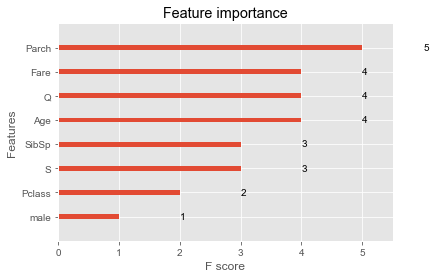

In [38]:
xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize'] = [5, 5]
style.use('seaborn-ticks')
plt.show()

In [13]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))

    return alg
#     feat_imp = pd.Series(alg.get_booster().get_fscore())
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [14]:
train  = pd.concat([X_train, y_train], axis=1)
target = 'Survived'
IDcol = 'PassengerId'

In [15]:
train.head()

,Pclass,Age,SibSp,Parch,Fare,youngin,male,Q,S,Survived
PassengerId,,,,,,,,,,
740,3,24.0,0,0,7.8958,0,1,0,1,0
148,3,9.0,2,2,34.3750,1,0,0,1,0
876,3,15.0,0,0,7.2250,0,0,0,0,1
641,3,20.0,0,0,7.8542,0,1,0,1,0
885,3,25.0,0,0,7.0500,0,1,0,1,0


In [16]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

alg = modelfit(xgb1, train, predictors, target)


Model Report
Accuracy : 0.8829
AUC Score (Train): 0.928483


In [17]:
preds = alg.predict(X_test)


test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.807175
F1: 0.703448


### Combining XGBoost with GridSearch

In [89]:
from sklearn.model_selection import GridSearchCV

In [90]:
#setup our parameters for XGBoost to test
param_test1 = {
    'max_depth': range(2, 9, 2),
    'min_child_weight': range(1, 6, 2),
    'colsample_bytree': [0.25, 0.5, 0.75, 1],
    'learning_rate':[0.1, 0.5, 0.75, 1]
}

In [91]:
# initiate the Gridsearch model
gsearch1 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        n_estimators=140,
        gamma=0,
        subsample=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27),
    param_grid=param_test1,
    scoring='f1',
    n_jobs=-1,
    iid=False,
    cv=5,
    verbose=2)

In [92]:
gsearch1.fit(train[predictors],train[target])


Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=140, n_jobs=1, nthread=4,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=True,
                                     subsample=0.8),
             iid=False, n_jobs=-1,
             param_grid={'colsample_bytree': [0.25, 0.5, 0.75, 1],
                         'learning_rate': [0.1, 0.5, 0.75, 1],
                         'max_depth': range(2, 9, 2),
                      

In [93]:
gsearch1.cv_results_

{'mean_fit_time': array([0.49651318, 0.36619024, 0.68214927, 0.29451685, 0.74787469,
        0.41753149, 0.58226886, 0.6652472 , 0.9921886 , 0.75122948,
        0.56691484, 0.44259305, 0.32657981, 0.40342135, 0.78108144,
        0.46262875, 0.51639576, 0.56081371, 0.35106997, 0.89667578,
        0.82985163, 0.88797078, 0.66622882, 0.26637149, 0.29865193,
        0.60628462, 0.5754365 , 0.49739799, 0.67642407, 0.33950434,
        0.69287343, 0.76548805, 0.62318363, 0.73056073, 0.49411659,
        0.67370701, 0.17178125, 0.59319944, 0.50767241, 0.64438162,
        0.37864304, 0.37937961, 0.56962013, 0.73113403, 0.88002124,
        0.56994619, 0.52082539, 0.76117516, 0.31871138, 0.60966253,
        0.3923243 , 0.51447349, 0.66927257, 0.64513292, 1.10198498,
        0.68994379, 0.80443802, 0.89430165, 1.47031336, 0.36728678,
        0.72036939, 0.4583344 , 0.40339837, 0.44456096, 0.52120628,
        0.83863111, 0.94748001, 0.41743798, 0.80258765, 0.92584367,
        0.51513638, 0.88765707,

In [94]:
gsearch1.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1}

In [95]:
gsearch1.best_score_

0.7954880413703943

In [96]:
preds = gsearch1.best_estimator_.predict(X_test)


test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.771300
F1: 0.657718


In [97]:
from xgboost import plot_importance

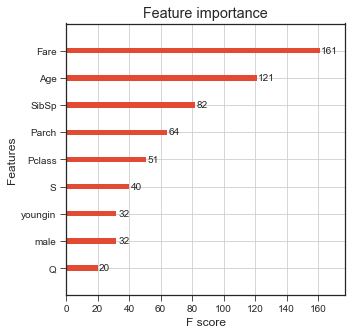

In [98]:

# plot feature importance
plot_importance(alg)


In [99]:
alg.get_booster().get_fscore()

{'S': 40,
 'Q': 20,
 'Fare': 161,
 'Parch': 64,
 'Pclass': 51,
 'SibSp': 82,
 'Age': 121,
 'male': 32,
 'youngin': 32}

## Saving a Model

In [100]:
xg_clf = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


In [101]:
import pickle

In [102]:
# pickle list object
 
model_pickle_path = 'xg_boost_model.pkl'

# Create an variable to pickle and open it in write mode
model_pickle = open(model_pickle_path, 'wb')
pickle.dump(gsearch1.best_estimator_, model_pickle)
model_pickle.close()

In [103]:
# Loading the saved XGboost model pickle
xgboost_model_pkl = open(model_pickle_path, 'rb')
xgboost_model = pickle.load(xgboost_model_pkl)
print("Loaded XGboost model :: ", xgboost_model)


Loaded XGboost model ::  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan, n_estimators=140,
              n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=True, subsample=0.8)


In [104]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [105]:
gridsearch_params

[(9, 5), (9, 6), (9, 7), (10, 5), (10, 6), (10, 7), (11, 5), (11, 6), (11, 7)]